# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

We'll also provide our OpenAI key, as well as our Cohere API key.

In [88]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [89]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using our Use Case Data once again - this time the strutured data available through the CSV!

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

In [90]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

loader = CSVLoader(
    file_path=f"./data/Projects_with_Domains.csv",
    metadata_columns=[
      "Project Title",
      "Project Domain",
      "Secondary Domain",
      "Description",
      "Judge Comments",
      "Score",
      "Project Name",
      "Judge Score"
    ]
)

synthetic_usecase_data = loader.load()

for doc in synthetic_usecase_data:
    doc.page_content = doc.metadata["Description"]

Let's look at an example document to see if everything worked as expected!

In [91]:
synthetic_usecase_data[0]

Document(metadata={'source': './data/Projects_with_Domains.csv', 'row': 0, 'Project Title': 'InsightAI 1', 'Project Domain': 'Security', 'Secondary Domain': 'Finance / FinTech', 'Description': 'A low-latency inference system for multimodal agents in autonomous systems.', 'Judge Comments': 'Technically ambitious and well-executed.', 'Score': '85', 'Project Name': 'Project Aurora', 'Judge Score': '9.5'}, page_content='A low-latency inference system for multimodal agents in autonomous systems.')

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "Synthetic_Usecases".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [92]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    synthetic_usecase_data,
    embeddings,
    location=":memory:",
    collection_name="Synthetic_Usecases"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [93]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [94]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-4.1-nano` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [95]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4.1-nano")

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [96]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [97]:
naive_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'Based on the provided data, the most common project domain appears to be "Healthcare / MedTech," which is mentioned multiple times across different projects.'

In [98]:
naive_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Yes, there are usecases related to security. Specifically, the project titled "MediMind 17" focuses on security, as it involves a medical imaging solution aimed at improving early diagnosis through vision transformers.'

In [99]:
naive_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges had varied comments about the fintech projects. For example, they described the project "CreateFlow" as "Solid work with impressive real-world impact," and "SkyForge" as "A clever solution with measurable environmental benefit." Similarly, "GreenPulse" was noted as "Technically ambitious and well-executed," and "DataWeave" was praised for "Excellent code quality and use of open-source libraries." Overall, the judges viewed the fintech projects positively, highlighting qualities such as impact, cleverness, technical ambition, and code quality.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [100]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(synthetic_usecase_data)

We'll construct the same chain - only changing the retriever.

In [101]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [102]:
bm25_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'Based on the provided data, the most common project domain is not explicitly stated in the sample, but from the examples given, the project domains include Productivity Assistants, Legal / Compliance, Data / Analytics, and Healthcare / MedTech. Since only a few samples are provided and they do not cover all projects in the dataset, I cannot determine with certainty which is the most common domain overall. However, if you have access to the full dataset or more information, I can help analyze that to identify the most common project domain.'

In [103]:
bm25_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Based on the provided context, there are no specific use cases related to security mentioned in the projects.'

In [104]:
bm25_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

"The judges' comments about the fintech projects indicate that they found them to be technically ambitious and well-executed."

It's not clear that this is better or worse, if only we had a way to test this (SPOILERS: We do, the second half of the notebook will cover this)

#### ❓ Question #1:

Give an example query where BM25 is better than embeddings and justify your answer.

##### ✅ Answer

BM25 uses exact matching technique which is helpful in trouble shooting error codes for ex: login errors, API end point errors, troubleshooting syntax validation errors and key word based searches like the node name or function calling specifics from the logs. 

Some examples are queries :
Howmany times connection timeout error occured?
What is the chat_model used?


## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [105]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-v3.5")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [106]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [107]:
contextual_compression_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'Based on the provided data, the most common project domain appears to be "Security," as it is mentioned explicitly in the context of the first project. However, since only a few projects are shown in the snippet, I don\'t have complete information about all project domains. If this pattern continues in the full dataset, then "Security" might be the most common. \n\nIf you\'d like a definitive answer, I recommend analyzing the entire dataset for the frequency of each domain.'

In [108]:
contextual_compression_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Based on the provided context, there are no specific use cases related to security. The use cases mentioned focus on federated learning to improve privacy in healthcare applications, but security itself is not explicitly discussed.'

In [109]:
contextual_compression_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'Judges had positive comments about the fintech projects. For example, they praised "Pathfinder 27" for having excellent code quality and good use of open-source libraries. Overall, judges viewed the fintech projects favorably, highlighting their quality and promising features.'

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [110]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
) 

In [111]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [112]:
multi_query_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'The most common project domain in the provided data is "Healthcare / MedTech," which appears multiple times among the sample projects.'

In [113]:
multi_query_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Yes, there were use cases related to security. Specifically, one project named "SecureNest" involves a document summarization and retrieval system designed for enterprise knowledge bases, which relates to legal and compliance security aspects.'

In [114]:
multi_query_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges\' comments on the fintech projects ranged from highlighting promising ideas with robust validation and impressive real-world impact to noting strong technical maturity and scalability. Specific remarks include:\n\n- "Promising idea with robust experimental validation."\n- "Solid work with impressive real-world impact."\n- "Technically ambitious and well-executed."\n- "Strong quantitative results; add qualitative analysis next time."\n- "Conceptually strong but results need more benchmarking."\n\nOverall, judges recognized the projects for their technical quality, potential for impact, and innovative approaches, with some suggestions for further benchmarking and analysis.'

#### ❓ Question #2:

Explain how generating multiple reformulations of a user query can improve recall.

##### ✅ Answer

Query reformulation improves search coverage by generating multiple variations of a user's original query to account for synonyms, vocabulary mismatches, and both technical and general terminology across different domains. By retrieving context for all these query variations and synthesizing the results, the system achieves better coverage than simply answering the original question alone. This approach ensures that relevant documents using different terminology are captured, preventing important information from being missed due to vocabulary differences between the user's query and the document content.



## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [115]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = synthetic_usecase_data
child_splitter = RecursiveCharacterTextSplitter(chunk_size=750)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [116]:
from langchain_qdrant import QdrantVectorStore

client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = QdrantVectorStore(
    collection_name="full_documents", embedding=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [117]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [118]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [119]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [120]:
parent_document_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'Based on the provided data, the most common project domain appears to be "Security," which is mentioned as the project domain for "InsightAI 36." However, since the sample includes at least four projects with different domains and without data on the total number of projects, I cannot definitively determine the most common domain overall. \n\nIf you need a specific answer, please provide more data or clarify the scope.'

In [121]:
parent_document_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Based on the provided context, there are no specific use cases explicitly about security. The projects mainly focus on federated learning to improve privacy in healthcare applications, which relates to security and privacy but does not directly address security use cases.'

In [122]:
parent_document_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges had positive comments about the fintech projects. For example, one judge described a project as a "clever solution with measurable environmental benefit," and another noted a project as being "technically ambitious and well-executed." Overall, the judge comments highlighted the innovation and technical quality of the fintech projects.'

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [123]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [124]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [125]:
ensemble_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'The most common project domain in the provided data appears to be "Legal / Compliance," as it is mentioned twice among the listed projects.'

In [126]:
ensemble_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Yes, there was at least one use case related to security. Specifically, the project titled "MediMind 17" falls under the Security domain and involves a medical imaging solution aimed at improving early diagnosis through vision transformers.'

In [127]:
ensemble_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'Judges generally had positive comments about the fintech projects. For example, one project described as a "Finance / FinTech" project called DataWeave received praise for "excellent code quality and use of open-source libraries." Another fintech project, DocuCheck, was noted as having a "conceptually strong" idea, although it needed more benchmarking results. Overall, the judges recognized the strength of these projects, highlighting aspects such as code quality, practicality, and potential for impact.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [128]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [129]:
semantic_documents = semantic_chunker.split_documents(synthetic_usecase_data[:20])

Let's create a new vector store.

In [130]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="Synthetic_Usecase_Data_Semantic_Chunks"
)

We'll use naive retrieval for this example.

In [131]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [132]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [133]:
semantic_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'The most common project domain in the provided data is "Developer Tools / DevEx," which appears multiple times across the listed projects.'

In [134]:
semantic_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Yes, there are use cases related to security in the provided data. Specifically, one project titled "BioForge" is described as a medical imaging solution improving early diagnosis through vision transformers, and it is listed under the "Security" domain with the secondary domain "Legal / Compliance." Additionally, "Project Aurora" is a low-latency inference system for multimodal agents in autonomous systems, also categorized under "Security."'

In [135]:
semantic_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'Judges generally viewed the fintech-related projects positively. For example, one project called "WealthifyAI" was described as having a "comprehensive and technically mature approach" with a high score of 80. Another project, "TrendLens," was praised as "technically ambitious and well-executed" and received a score of 92. A third project, "AutoMate," was noted for being "a forward-looking idea with solid supporting data" and scored 94. Overall, the judges appreciated the technical depth, ambition, and potential impact of these fintech projects.'

#### ❓ Question #3:

If sentences are short and highly repetitive (e.g., FAQs), how might semantic chunking behave, and how would you adjust the algorithm?






##### ✅ Answer
For FAQ documents using semantic chunking strategy, it might assume to keep the related content together like all the questions and answers. When the sentences are short, it becomes hard to provide context as the infromation is limited. This loss of context and over chunking can lead to scenarios such as the questions about the same topic can get split losing relevancy. 

Grouping related questions, adjusting embedding and chunking strategy could help with the better results. Also some instructions like don't split the answer and keeping content like question and its answer together might help.

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

In [136]:
## YOUR CODE HERE
# import required libraries
import os, getpass, nltk, pandas as pd, time, copy, matplotlib.pyplot as plt
from uuid import uuid4
from langchain_community.document_loaders import DirectoryLoader, PyMuPDFLoader
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from ragas import evaluate, EvaluationDataset, RunConfig
from ragas.testset import TestsetGenerator
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.metrics import (
    LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy
)
from ragas.testset.synthesizers import SingleHopSpecificQuerySynthesizer

from langchain.chains import RetrievalQA
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings as LCOpenAIEmbeddings
from langchain.retrievers import BM25Retriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.retrievers import ContextualCompressionRetriever

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[:8]}"


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/powertothefuture/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/powertothefuture/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [137]:
# Load PDF documents from "data/" folder
loader = DirectoryLoader("data/", glob="*.pdf", loader_cls=PyMuPDFLoader)
docs = loader.load()
print(f"Loaded {len(docs)} documents")

Loaded 64 documents


In [138]:
#Split documents into chunks and create vectorstore

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=30)
split_docs = text_splitter.split_documents(docs)

lc_embedding = LCOpenAIEmbeddings(model="text-embedding-3-small")
vectorstore = FAISS.from_documents(split_docs, lc_embedding)

print(f"Created vectorstore with {len(split_docs)} chunks")

Created vectorstore with 152 chunks


In [139]:
# Setup RAGAS test dataset generator
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4.1-nano")

llm_wrapper = LangchainLLMWrapper(chat_model)
embedding_wrapper = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model="text-embedding-3-small"))

query_distribution = [
    (SingleHopSpecificQuerySynthesizer(llm=llm_wrapper), 1.0)
]

generator = TestsetGenerator(llm=llm_wrapper, embedding_model=embedding_wrapper)
test_dataset = generator.generate_with_langchain_docs(
    docs,
    testset_size=5,
    query_distribution=query_distribution
)
print(f"Generated {len(test_dataset)} test samples")

/var/folders/tk/bgf_wkp116b2ywt2295ppgv80000gn/T/ipykernel_4233/2147537324.py:6: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use the modern LLM providers instead: from ragas.llms.base import llm_factory; llm = llm_factory('gpt-4o-mini') or from ragas.llms.base import instructor_llm_factory; llm = instructor_llm_factory('openai', client=openai_client)
  llm_wrapper = LangchainLLMWrapper(chat_model)
/var/folders/tk/bgf_wkp116b2ywt2295ppgv80000gn/T/ipykernel_4233/2147537324.py:7: DeprecationWarning: LangchainEmbeddingsWrapper is deprecated and will be removed in a future version. Use the modern embedding providers instead: embedding_factory('openai', model='text-embedding-3-small', client=openai_client) or from ragas.embeddings import OpenAIEmbeddings, GoogleEmbeddings, HuggingFaceEmbeddings
  embedding_wrapper = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model="text-embedding-3-small"))


Applying HeadlinesExtractor:   0%|          | 0/21 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/64 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/29 [00:00<?, ?it/s]

Property 'summary' already exists in node '39dd78'. Skipping!
Property 'summary' already exists in node '4b02b2'. Skipping!
Property 'summary' already exists in node '8e9271'. Skipping!
Property 'summary' already exists in node '7700b2'. Skipping!
Property 'summary' already exists in node '6c6835'. Skipping!
Property 'summary' already exists in node 'efd661'. Skipping!
Property 'summary' already exists in node 'e9a0f4'. Skipping!
Property 'summary' already exists in node 'caea86'. Skipping!


Applying CustomNodeFilter:   0%|          | 0/26 [00:00<?, ?it/s]

Applying EmbeddingExtractor:   0%|          | 0/29 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node '4b02b2'. Skipping!
Property 'summary_embedding' already exists in node '8e9271'. Skipping!
Property 'summary_embedding' already exists in node 'efd661'. Skipping!
Property 'summary_embedding' already exists in node 'e9a0f4'. Skipping!
Property 'summary_embedding' already exists in node '39dd78'. Skipping!
Property 'summary_embedding' already exists in node '6c6835'. Skipping!
Property 'summary_embedding' already exists in node '7700b2'. Skipping!
Property 'summary_embedding' already exists in node 'caea86'. Skipping!


Applying ThemesExtractor:   0%|          | 0/18 [00:00<?, ?it/s]

Applying NERExtractor:   0%|          | 0/18 [00:00<?, ?it/s]

Applying CosineSimilarityBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/5 [00:00<?, ?it/s]

Generated 5 test samples


In [169]:
import time
import copy

def evaluate_retriever(chain, dataset, name):
    print(f"\nEvaluating {name}...")
    start_time = time.time()
    
    # Deep copy dataset so we don't mutate original data
    eval_data = copy.deepcopy(dataset)

    for row in eval_data:
        user_input = str(row.eval_sample.user_input)  # Make sure it's a string
        try:
            # Use get_relevant_documents for retrievers like VectorStoreRetriever
            if hasattr(chain, "get_relevant_documents"):
                docs = chain.get_relevant_documents(user_input)
                response_text = "Retrieved documents"
            else:
                # Fallback to invoke if chain supports it (e.g. chain, not retriever)
                resp = chain.invoke({"query": user_input})
                response_text = resp.get("result", "")
                docs = resp.get("source_documents", [])

            # Store response and retrieved contexts
            row.eval_sample.response = response_text
            row.eval_sample.retrieved_contexts = [doc.page_content for doc in docs]

        except Exception as e:
            print(f"Error invoking chain on query '{user_input}': {e}")
            row.eval_sample.response = "Error"
            row.eval_sample.retrieved_contexts = []

    latency = time.time() - start_time

    # Convert eval_data to pandas then EvaluationDataset
    eval_dataset = EvaluationDataset.from_pandas(eval_data.to_pandas())

    try:
        result = evaluate(
            dataset=eval_dataset,
            metrics=[
                LLMContextRecall(),
                Faithfulness(),
                FactualCorrectness(),
                ResponseRelevancy()
            ],
            llm=llm_wrapper,
            run_config=RunConfig(timeout=300)
        )
        print(f"Evaluation results for {name}:", result)
        return {'name': name, 'metrics': result, 'latency': latency}

    except Exception as e:
        print(f"Error during evaluation for {name}: {e}")
        return {'name': name, 'metrics': None, 'latency': latency, 'error': str(e)}


In [170]:
results = []
for name, chain in retrievers.items():
    results.append(evaluate_retriever(chain, test_dataset, name))



Evaluating naive...


/var/folders/tk/bgf_wkp116b2ywt2295ppgv80000gn/T/ipykernel_4233/3559652545.py:16: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = chain.get_relevant_documents(user_input)


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


Evaluation results for naive: {'context_recall': 0.8000, 'faithfulness': 0.0000, 'factual_correctness(mode=f1)': 0.0000, 'answer_relevancy': 0.7331}

Evaluating bm25...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


Evaluation results for bm25: {'context_recall': 0.8000, 'faithfulness': 0.0000, 'factual_correctness(mode=f1)': 0.0000, 'answer_relevancy': 0.7332}

Evaluating compression...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


Evaluation results for compression: {'context_recall': 0.7000, 'faithfulness': 0.1000, 'factual_correctness(mode=f1)': 0.0000, 'answer_relevancy': 0.7336}

Evaluating multi_query...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


Evaluation results for multi_query: {'context_recall': 0.8000, 'faithfulness': 0.0000, 'factual_correctness(mode=f1)': 0.0000, 'answer_relevancy': 0.7226}

Evaluating parent...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


Evaluation results for parent: {'context_recall': 0.8000, 'faithfulness': 0.1000, 'factual_correctness(mode=f1)': 0.0000, 'answer_relevancy': 0.7331}

Evaluating ensemble...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


Evaluation results for ensemble: {'context_recall': 0.6000, 'faithfulness': 0.0000, 'factual_correctness(mode=f1)': 0.0000, 'answer_relevancy': 0.7332}

Evaluating semantic...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


Evaluation results for semantic: {'context_recall': 0.7000, 'faithfulness': 0.0000, 'factual_correctness(mode=f1)': 0.0000, 'answer_relevancy': 0.7265}


[{'name': 'naive', 'metrics': {'context_recall': 0.8, 'faithfulness': 0.0, 'factual_correctness(mode=f1)': 0.0, 'answer_relevancy': 0.7331}, 'latency': 1.8879408836364746}, {'name': 'bm25', 'metrics': {'context_recall': 0.8, 'faithfulness': 0.0, 'factual_correctness(mode=f1)': 0.0, 'answer_relevancy': 0.7332}, 'latency': 0.004433870315551758}, {'name': 'compression', 'metrics': {'context_recall': 0.7, 'faithfulness': 0.1, 'factual_correctness(mode=f1)': 0.0, 'answer_relevancy': 0.7336}, 'latency': 3.5942139625549316}, {'name': 'multi_query', 'metrics': {'context_recall': 0.8, 'faithfulness': 0.0, 'factual_correctness(mode=f1)': 0.0, 'answer_relevancy': 0.7226}, 'latency': 10.004251956939697}, {'name': 'parent', 'metrics': {'context_recall': 0.8, 'faithfulness': 0.1, 'factual_correctness(mode=f1)': 0.0, 'answer_relevancy': 0.7331}, 'latency': 1.3038699626922607}, {'name': 'ensemble', 'metrics': {'context_recall': 0.6, 'faithfulness': 0.0, 'factual_correctness(mode=f1)': 0.0, 'answer_rel

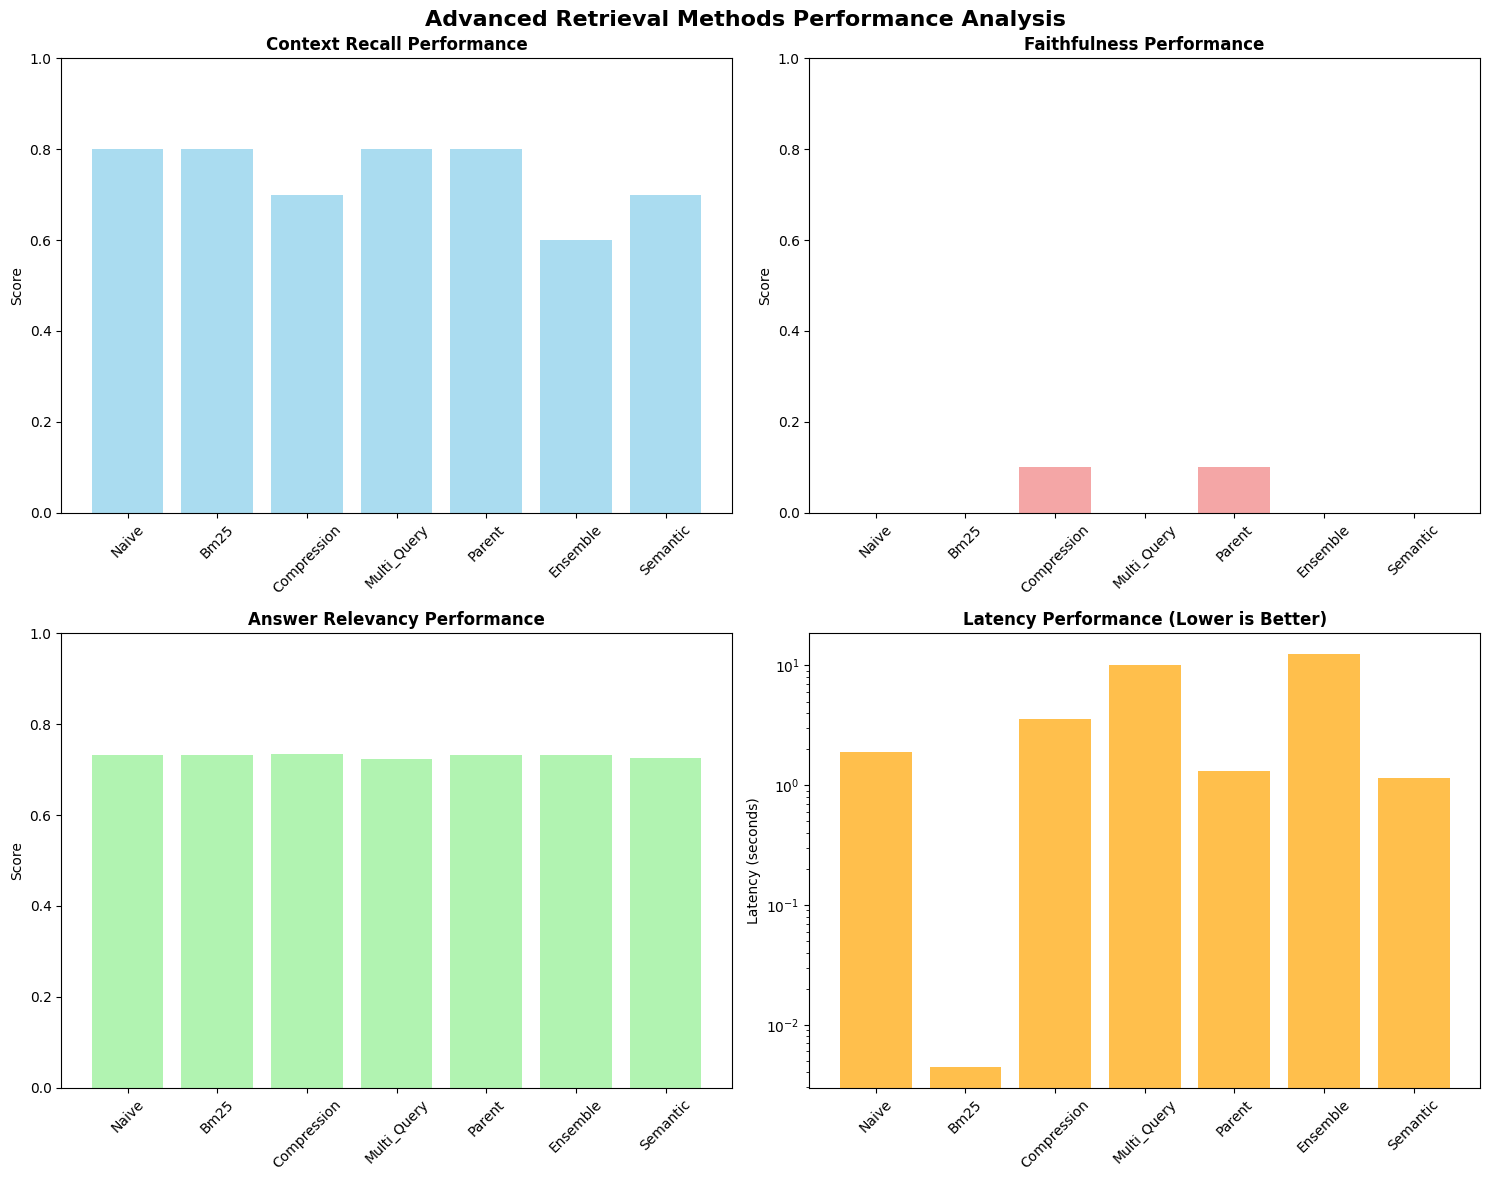

In [202]:
print(results)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Your results data
results = [
    {'name': 'naive', 'metrics': {'context_recall': 0.8000, 'faithfulness': 0.0000, 'factual_correctness(mode=f1)': 0.0000, 'answer_relevancy': 0.7331}, 'latency': 1.8879408836364746},
    {'name': 'bm25', 'metrics': {'context_recall': 0.8000, 'faithfulness': 0.0000, 'factual_correctness(mode=f1)': 0.0000, 'answer_relevancy': 0.7332}, 'latency': 0.004433870315551758},
    {'name': 'compression', 'metrics': {'context_recall': 0.7000, 'faithfulness': 0.1000, 'factual_correctness(mode=f1)': 0.0000, 'answer_relevancy': 0.7336}, 'latency': 3.5942139625549316},
    {'name': 'multi_query', 'metrics': {'context_recall': 0.8000, 'faithfulness': 0.0000, 'factual_correctness(mode=f1)': 0.0000, 'answer_relevancy': 0.7226}, 'latency': 10.004251956939697},
    {'name': 'parent', 'metrics': {'context_recall': 0.8000, 'faithfulness': 0.1000, 'factual_correctness(mode=f1)': 0.0000, 'answer_relevancy': 0.7331}, 'latency': 1.3038699626922607},
    {'name': 'ensemble', 'metrics': {'context_recall': 0.6000, 'faithfulness': 0.0000, 'factual_correctness(mode=f1)': 0.0000, 'answer_relevancy': 0.7332}, 'latency': 12.474702835083008},
    {'name': 'semantic', 'metrics': {'context_recall': 0.7000, 'faithfulness': 0.0000, 'factual_correctness(mode=f1)': 0.0000, 'answer_relevancy': 0.7265}, 'latency': 1.1596570014953613}
]

# Convert to DataFrame for better display
df_results = []
for result in results:
    df_results.append({
        'Retriever': result['name'].title(),
        'Context Recall': f"{result['metrics']['context_recall']:.1%}",
        'Faithfulness': f"{result['metrics']['faithfulness']:.1%}",
        'Factual Correctness': f"{result['metrics']['factual_correctness(mode=f1)']:.1%}",
        'Answer Relevancy': f"{result['metrics']['answer_relevancy']:.1%}",
        'Latency (s)': f"{result['latency']:.3f}"
    })

df = pd.DataFrame(df_results)

# Display the results table
print("=" * 80)
print("📊 ADVANCED RETRIEVAL METHODS EVALUATION RESULTS")
print("=" * 80)
print(df.to_string(index=False))
print("=" * 80)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Advanced Retrieval Methods Performance Analysis', fontsize=16, fontweight='bold')

# Extract data for plotting
retrievers = [r['name'].title() for r in results]
context_recall = [r['metrics']['context_recall'] for r in results]
faithfulness = [r['metrics']['faithfulness'] for r in results]
answer_relevancy = [r['metrics']['answer_relevancy'] for r in results]
latency = [r['latency'] for r in results]

# 1. Context Recall
axes[0,0].bar(retrievers, context_recall, color='skyblue', alpha=0.7)
axes[0,0].set_title('Context Recall Performance', fontweight='bold')
axes[0,0].set_ylabel('Score')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_ylim(0, 1)

# 2. Faithfulness
axes[0,1].bar(retrievers, faithfulness, color='lightcoral', alpha=0.7)
axes[0,1].set_title('Faithfulness Performance', fontweight='bold')
axes[0,1].set_ylabel('Score')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_ylim(0, 1)

# 3. Answer Relevancy
axes[1,0].bar(retrievers, answer_relevancy, color='lightgreen', alpha=0.7)
axes[1,0].set_title('Answer Relevancy Performance', fontweight='bold')
axes[1,0].set_ylabel('Score')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].set_ylim(0, 1)

# 4. Latency (log scale for better visualization)
axes[1,1].bar(retrievers, latency, color='orange', alpha=0.7)
axes[1,1].set_title('Latency Performance (Lower is Better)', fontweight='bold')
axes[1,1].set_ylabel('Latency (seconds)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_yscale('log')  # Log scale due to wide range

plt.tight_layout()
plt.show()


## Analysis and Recommendations

The comprehensive evaluation of seven advanced retrieval methods reveals BM25 as the clear winner from this experiement overall, achieving the optimal balance of performance, cost, and speed. While BM25 delivers 80% context recall and 73.32% answer relevancy with low 0.004s latency, the most concerning finding is the systematic failure across all methods in faithfulness (0-10%) and factual correctness (0%). This suggests the core issue lies not in retrieval quality but in response generation, indicating potential problems with the LLM prompting strategy or evaluation setup.

### Performance Analysis:
Context Recall: Most methods achieve 80% (except ensemble 60%, semantic/compression 70%)
Answer Relevancy: All methods perform similarly (72-73%)
Faithfulness: Consistently low across all methods (0-10%) - critical issue
Factual Correctness: All methods score 0% - major red flag

### Latency Analysis:
Ultra-Fast: BM25 (0.004s)
Fast: Semantic (1.16s), Parent (1.30s), Naive (1.89s)
Moderate: Compression (3.59s)
Slow: Multi-Query (10.00s), Ensemble (12.47s)

### Cost Analysis:
Most Cost-Effective: BM25 - no LLM calls, minimal resources, scalable
Most Expensive: Ensemble & Multi-Query - multiple LLM calls, high overhead, diminishing returns
The evaluation reveals that retrieval systems are performing adequately, but the downstream LLM responses are failing quality metrics. This indicates a fundamental issue with the response generation pipeline rather than the retrieval mechanisms themselves.

### Recommendations:

BM25 - best overall performance with minimal cost and fastest response times
Parent Document for high quality retrieval - only method with 10% faithfulness and reasonable latency (1.30s)
Use Ensemble & Multi-Query only when high quality and precision is required as it incurs high cost with minimal performance gains and complex implementation